<a href="https://colab.research.google.com/github/ShubhangiSRG24/AI-project-/blob/main/SentimentAnalysis_financialNewsdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Sentiment Analysis using GRU

In [ ]:
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [ ]:
data = pd.read_csv('/content/SilDataScored.csv', names=['Label', 'headline'], encoding='latin-1')

In [ ]:
data

,Label,headline
0,negative,Will Silicon Valley Bank's collapse spark a US...
1,neutral,Silicon Valley Bank failed. Here's how and why...
2,negative,Op-ed: The Silicon Valley Bank bailout won't s...
3,neutral,Justice Department opens probe into Silicon Va...
4,neutral,HSBC pays £1 to rescue UK arm of Silicon Vall...
...,...,...
524,neutral,SVB in focus as Chinese officials warn of US r...
525,neutral,How the Banking Crisis Has Had the Same Effect...
526,neutral,How a Trump-Era Rollback Mattered for Silicon ...
527,neutral,Low Rates Were Meant to Last. Without Them Fin...


In [ ]:
import nltk
import random
from nltk.corpus import wordnet

nltk.download('wordnet')

def oversample_with_word_substitution(data, target_class, desired_count):
    class_data = data[data['Label'] == target_class]

    while len(class_data) < desired_count:
        # Randomly select an instance from the class
        random_instance = class_data.sample(n=1)

        # Apply word substitution using WordNet
        original_headline = random_instance['headline'].values[0]
        substituted_headline = []

        for word in original_headline.split():
            synsets = wordnet.synsets(word)
            if synsets:
                random_synset = random.choice(synsets)
                substituted_word = random_synset.lemmas()[0].name()
                substituted_headline.append(substituted_word)
            else:
                substituted_headline.append(word)

        substituted_headline = ' '.join(substituted_headline)

        # Add the substituted headline to the oversampled data
        class_data = class_data.append({'headline': substituted_headline, 'Label': target_class}, ignore_index=True)

    return class_data

# Separate data by classes
positive_data = data[data['Label'] == 'positive']
negative_data = data[data['Label'] == 'negative']
neutral_data = data[data['Label'] == 'neutral']

# Oversample each class with word substitution
oversampled_positive = oversample_with_word_substitution(positive_data, 'positive', 500)
oversampled_negative = oversample_with_word_substitution(negative_data, 'negative', 500)
oversampled_neutral = oversample_with_word_substitution(neutral_data, 'neutral', 500)

# Concatenate the oversampled data
oversampled_data = pd.concat([oversampled_positive, oversampled_negative, oversampled_neutral], axis=0)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
oversampled_data

,Label,headline
0,positive,Yellen: Bank savings 'remain safe' after Silic...
1,positive,Chalmers says banks are safe as markets dump r...
2,positive,SVB collapse: How Google Microsoft and Amazon ...
3,positive,SVB collapse will boost Chinese stocks by slow...
4,positive,Key lawmakers say upcoming hearings on bank fa...
...,...,...
495,neutral,silicon valley bank sulfur rear company file f...
496,neutral,faith in bank plummet Among affluent American_...
497,neutral,The curse of virality from house party to sili...
498,neutral,key_signature bank mho flop fuel aside Crypto ...


In [ ]:
oversampled_data.shape
oversampled_data.info()
data2 = oversampled_data
column_mapping = {
    'Label': 'Label',
    'headline': 'Text'
}

# Rename the columns using the mapping
data2 = data2.rename(columns=column_mapping)

data3 = oversampled_data.copy()
data3 = data3.rename(columns=column_mapping)
data3.to_csv('oversampled_data.csv', index=False)

import os
print(os.getcwd())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Label     1500 non-null   object
 1   headline  1500 non-null   object
dtypes: object(2)
memory usage: 35.2+ KB
/content


In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   1500 non-null   object
 1   Text    1500 non-null   object
dtypes: object(2)
memory usage: 35.2+ KB


## Preprocessing

In [ ]:
def get_sequences(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)

    sequences = tokenizer.texts_to_sequences(texts)
    print("Vocab length:", len(tokenizer.word_index) + 1)

    max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
    print("Maximum sequence length:", max_seq_length)

    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

    return sequences

In [ ]:
def preprocess_inputs2(df):
    df = df.copy()

    sequences = get_sequences(df['Text'])

    label_mapping = {
        'negative': 0,
        'neutral': 1,
        'positive': 2
    }

    y = df['Label'].replace(label_mapping)

    train_sequences, test_sequences, y_train, y_test = train_test_split(sequences, y, train_size=0.5, shuffle=True, random_state=1)

    return train_sequences, test_sequences, y_train, y_test

In [ ]:
train_sequences2, test_sequences2, y_train2, y_test2 = preprocess_inputs2(data2)

Vocab length: 2294
Maximum sequence length: 22


In [ ]:
train_sequences2

array([[465, 443,  40, ...,   0,   0,   0],
       [  2,   3,  46, ...,   0,   0,   0],
       [181, 209,   7, ...,   0,   0,   0],
       ...,
       [  4, 905,   2, ...,   0,   0,   0],
       [ 89, 416, 154, ...,   0,   0,   0],
       [  2,   3,  46, ...,   0,   0,   0]], dtype=int32)



```
# This is formatted as code
```

## Training with GRU for small dataset

In [ ]:
inputs = tf.keras.Input(shape=(train_sequences2.shape[1],))
x = tf.keras.layers.Embedding(
    input_dim=2294 ,#1812, #1546
    output_dim=128,
    input_length=train_sequences2.shape[1]
)(inputs)
x = tf.keras.layers.GRU(256, return_sequences=True, activation='tanh')(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model2.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model2.fit(
    train_sequences2,
    y_train2,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
19/19 [==============================] - 9s 244ms/step - loss: 1.0559 - accuracy: 0.4983 - val_loss: 0.9694 - val_accuracy: 0.5067
Epoch 2/100
19/19 [==============================] - 2s 90ms/step - loss: 0.6857 - accuracy: 0.6983 - val_loss: 0.5716 - val_accuracy: 0.7933
Epoch 3/100
19/19 [==============================] - 3s 146ms/step - loss: 0.3434 - accuracy: 0.9133 - val_loss: 0.5504 - val_accuracy: 0.7867
Epoch 4/100
19/19 [==============================] - 3s 139ms/step - loss: 0.1028 - accuracy: 0.9650 - val_loss: 0.7559 - val_accuracy: 0.7867
Epoch 5/100
19/19 [==============================] - 2s 86ms/step - loss: 0.0214 - accuracy: 0.9950 - val_loss: 0.7928 - val_accuracy: 0.8133
Epoch 6/100
19/19 [==============================] - 2s 90ms/step - loss: 0.0128 - accuracy: 0.9967 - val_loss: 0.8909 - val_accuracy: 0.7933


In [ ]:
results2 = model2.evaluate(test_sequences2, y_test2, verbose=0)

print("    Test Loss: {:.5f}".format(results2[0]))
print("Test Accuracy: {:.2f}%".format(results2[1] * 100))

    Test Loss: 0.40165
Test Accuracy: 82.53%


##Sentiment Analysis by finetuning BERT

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pd.read_csv('/content/oversampled_alterloc.csv')
df.shape

(1500, 2)

In [ ]:
df.head()
# Let's check for missing values
df.isnull().sum()

Title              0
Sentiment_Label    0
dtype: int64

In [ ]:
# Function to convert score to sentiment
def to_sentiment(rating):

    # Convert to class
    if rating == "negative":
        return 0
    elif rating == "neutral":
        return 1
    elif rating == "positive":
        return 2

# Apply to the dataset
df['sentiment'] = df.Sentiment_Label.apply(to_sentiment)


### Data Preprocessing for BERT

For Bert like ML models - convert text to numerical representation. It requires more attention when it comes to this representation.

Here are the requirements:

Add special tokens[SEP] to separate sentences and do classification
Pass sequences of constant length
(introduce padding) - create array of 0s (pad token) and 1s (real token) called attention mask
BERT offers 2 model architectures and I will be using the uncased version where the text is lowercased before tokenization step

The tokenizer will break the sentence into words and give numerical values to each word.

In [ ]:
# Set the model name
MODEL_NAME = 'bert-base-uncased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [ ]:
# Store length of each title
token_lens = []

# Iterate through the title column
for txt in df.Title:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

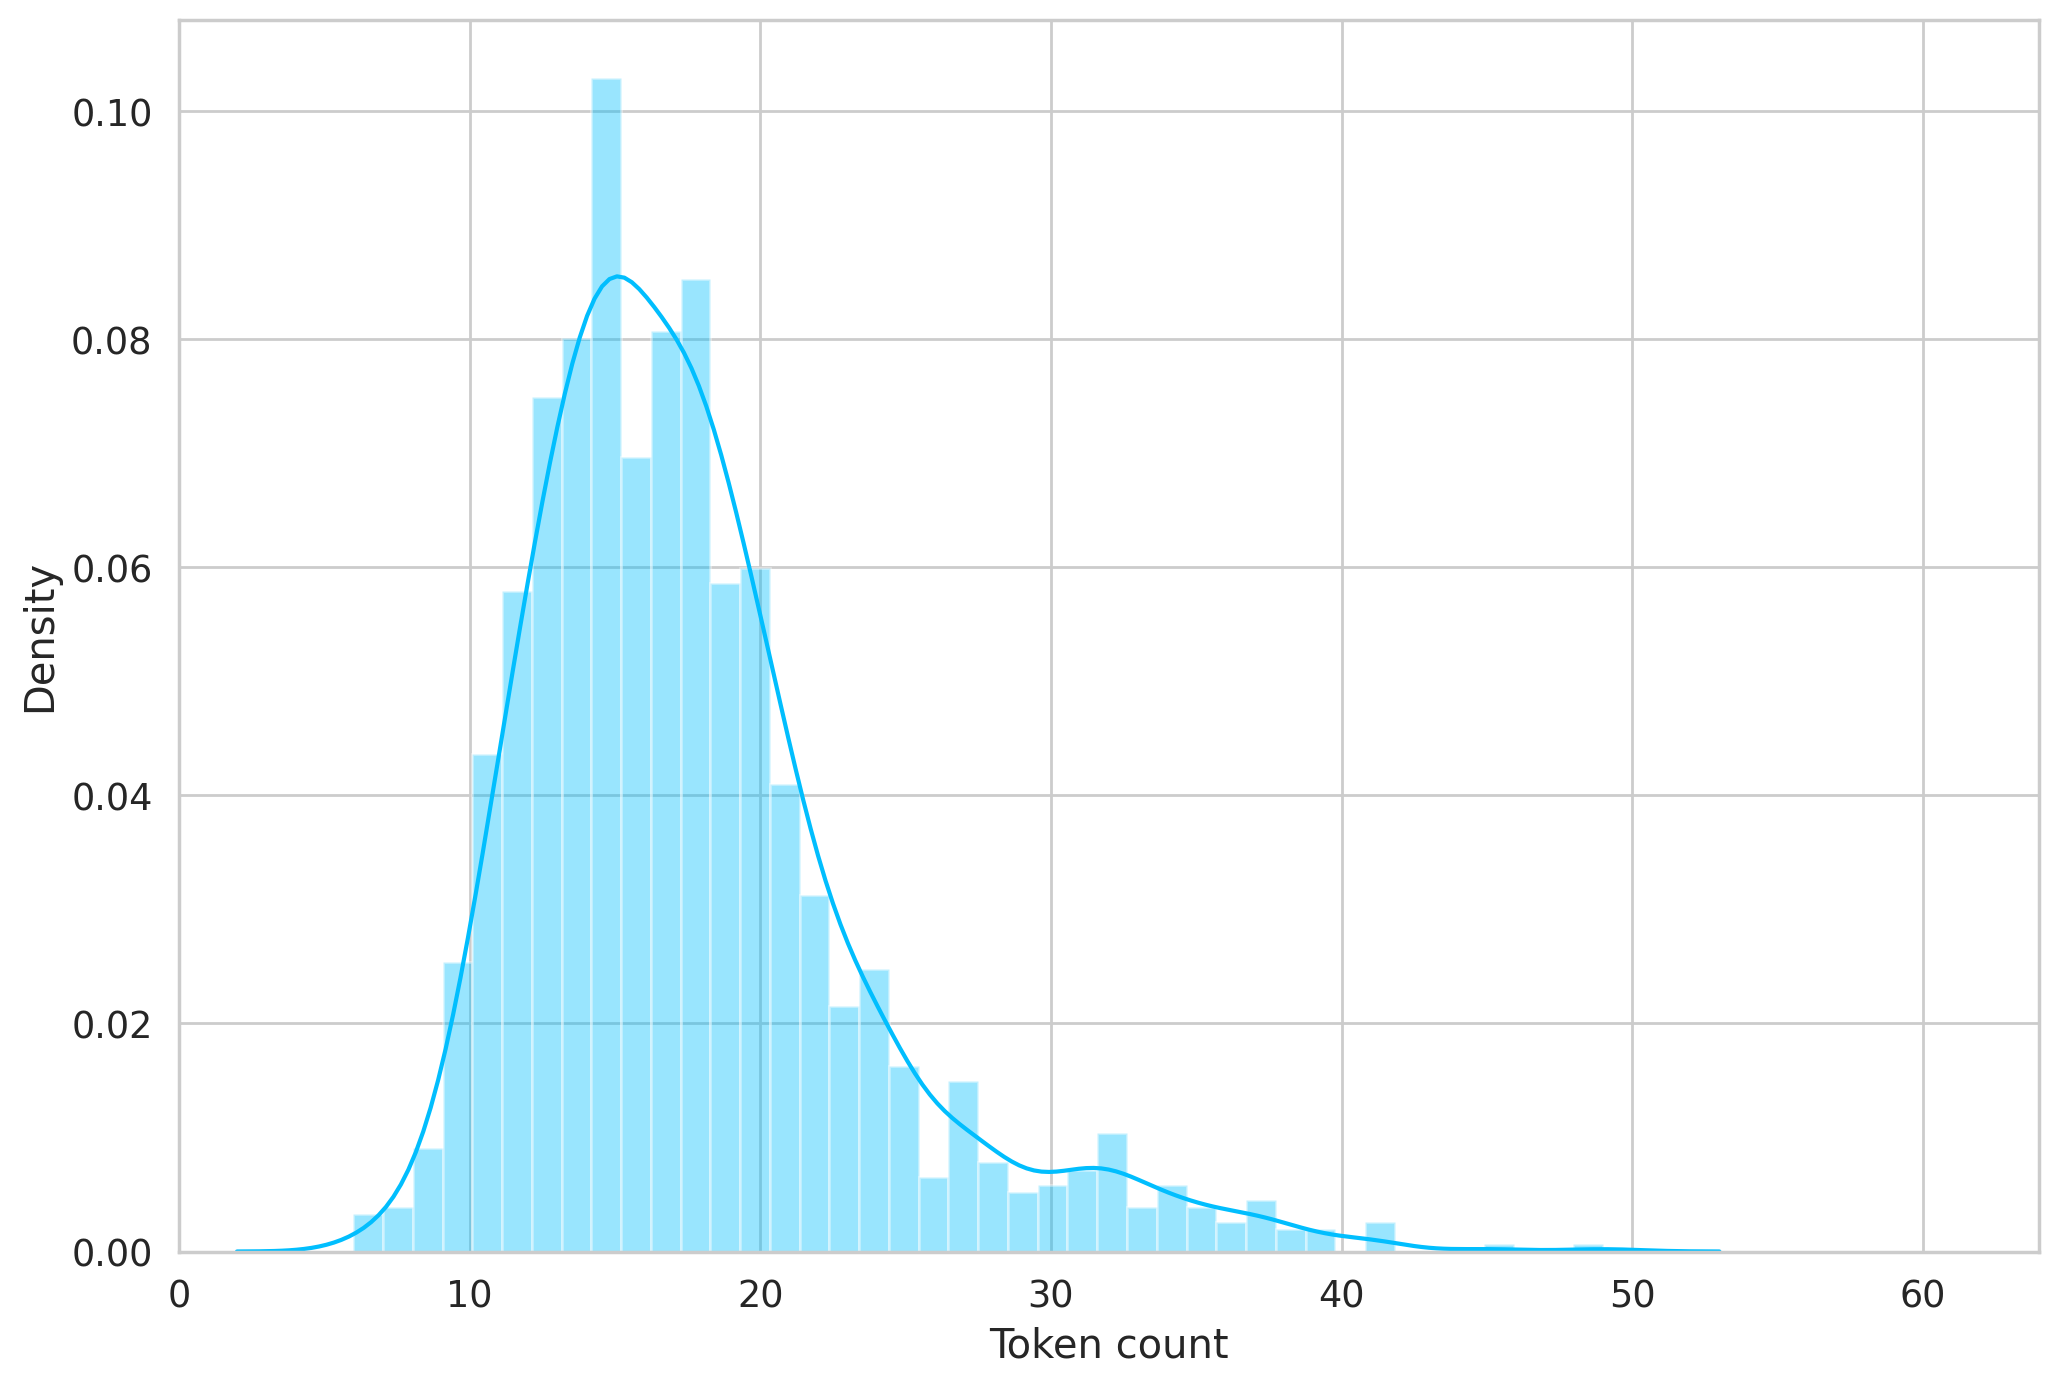

In [ ]:
# plot the distribution of Title lengths
sns.distplot(token_lens)
plt.xlim([0, 64]);
plt.xlabel('Token count')

MAX_LEN = 35

In [ ]:
class GoogleNewsDataset(Dataset):
    # Constructor Function
    def __init__(self, news, labels, tokenizer, max_len):
        self.news = news
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.news)

    # get item magic method
    def __getitem__(self, item):
        news = str(self.news[item])
        labels = self.labels[item]

        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus( # tokenize and encode the news text. It adds special tokens, limits the maximum length (max_len), pads the sequence to the maximum length, and returns tensors in PyTorch format
            news,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'News_text': news,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.long)
        }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(1200, 3) (150, 3) (150, 3)


In [ ]:
#data loader to have data in batches
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GoogleNewsDataset(
        news=df.Title.to_numpy(),
        labels=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Examples
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['News_text', 'input_ids', 'attention_mask', 'labels'])
torch.Size([16, 35])
torch.Size([16, 35])
torch.Size([16])


#Sentiment Classification with bert

In [ ]:
# Load the basic BERT model
bert_model = BertModel.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
# Instantiate the model and move to classifier
class_names = ['negative', 'neutral', 'positive']
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


#training phase
use the AdamW optimizer provided by Hugging Face. It corrects weight decay.

In [ ]:
# Number of iterations
EPOCHS = 10

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
#evaluate model performance

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.8971508232752482 accuracy 0.565
Val   loss 0.45623910129070283 accuracy 0.8533333333333334

Epoch 2/10
----------
Train loss 0.3467976130048434 accuracy 0.8866666666666667
Val   loss 0.4876498758792877 accuracy 0.8333333333333334

Epoch 3/10
----------
Train loss 0.10536418986196319 accuracy 0.965
Val   loss 0.38633109328802673 accuracy 0.92

Epoch 4/10
----------
Train loss 0.03139776487679531 accuracy 0.9916666666666667
Val   loss 0.5052054511150346 accuracy 0.9

Epoch 5/10
----------
Train loss 0.008812258314962188 accuracy 0.9983333333333333
Val   loss 0.45089933754643424 accuracy 0.9266666666666666

Epoch 6/10
----------
Train loss 0.009979204308862488 accuracy 0.9983333333333333
Val   loss 0.5144009980373084 accuracy 0.9133333333333333

Epoch 7/10
----------
Train loss 0.0006247408331061403 accuracy 1.0
Val   loss 0.52172762627888 accuracy 0.9133333333333333

Epoch 8/10
----------
Train loss 0.0005708934894452492 accuracy 1.0
Val   loss 0.665007

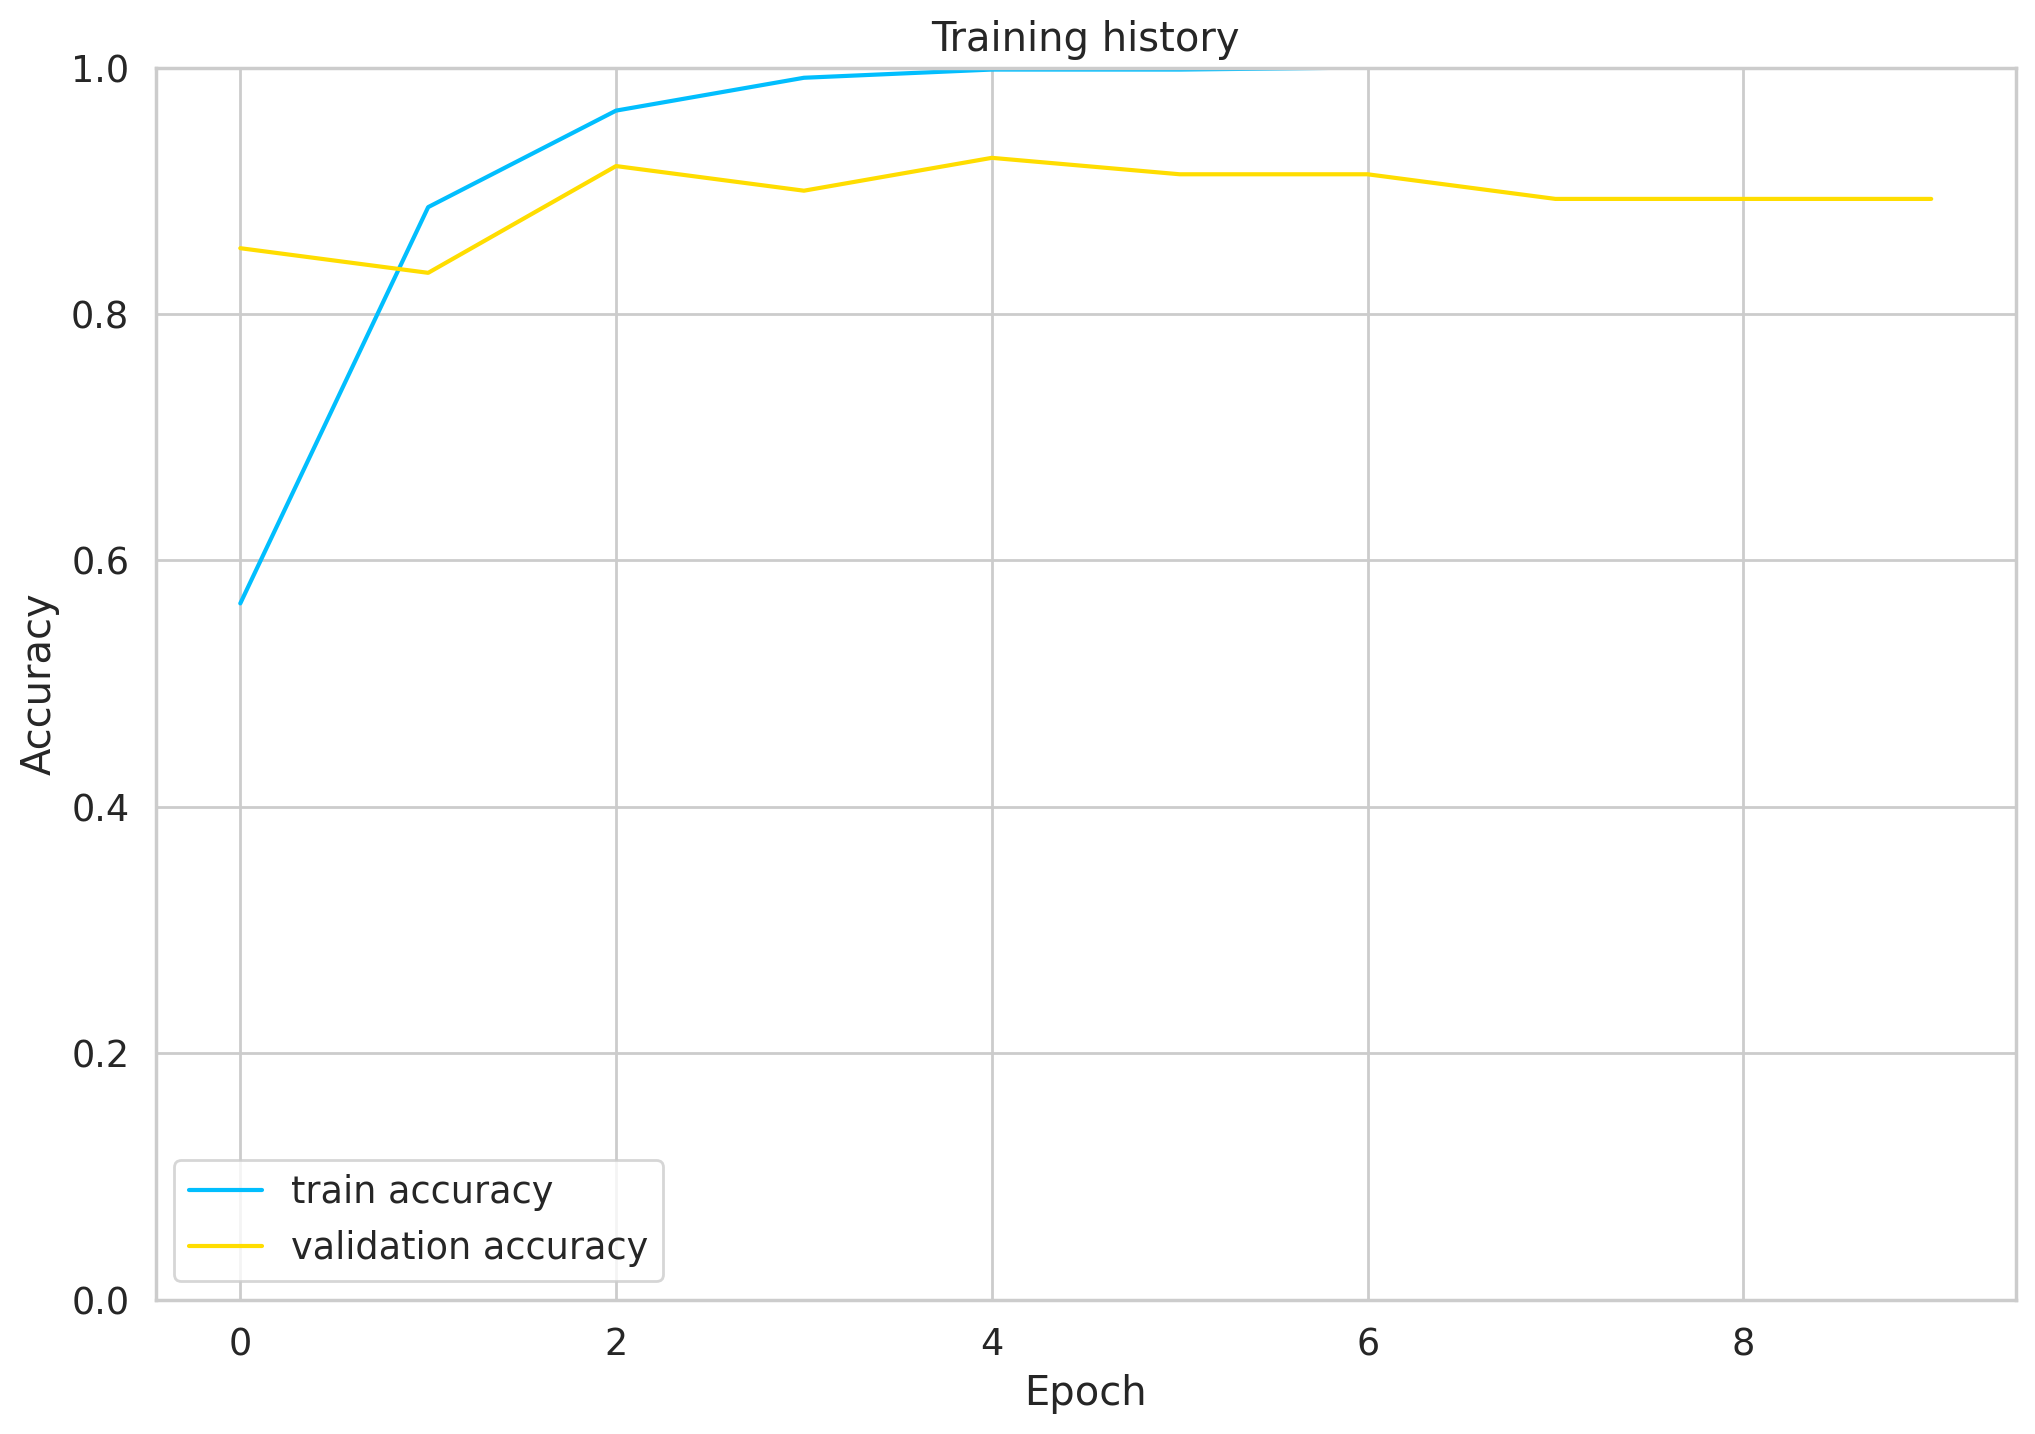

In [ ]:
# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Accuracy: 0.9133333333333333


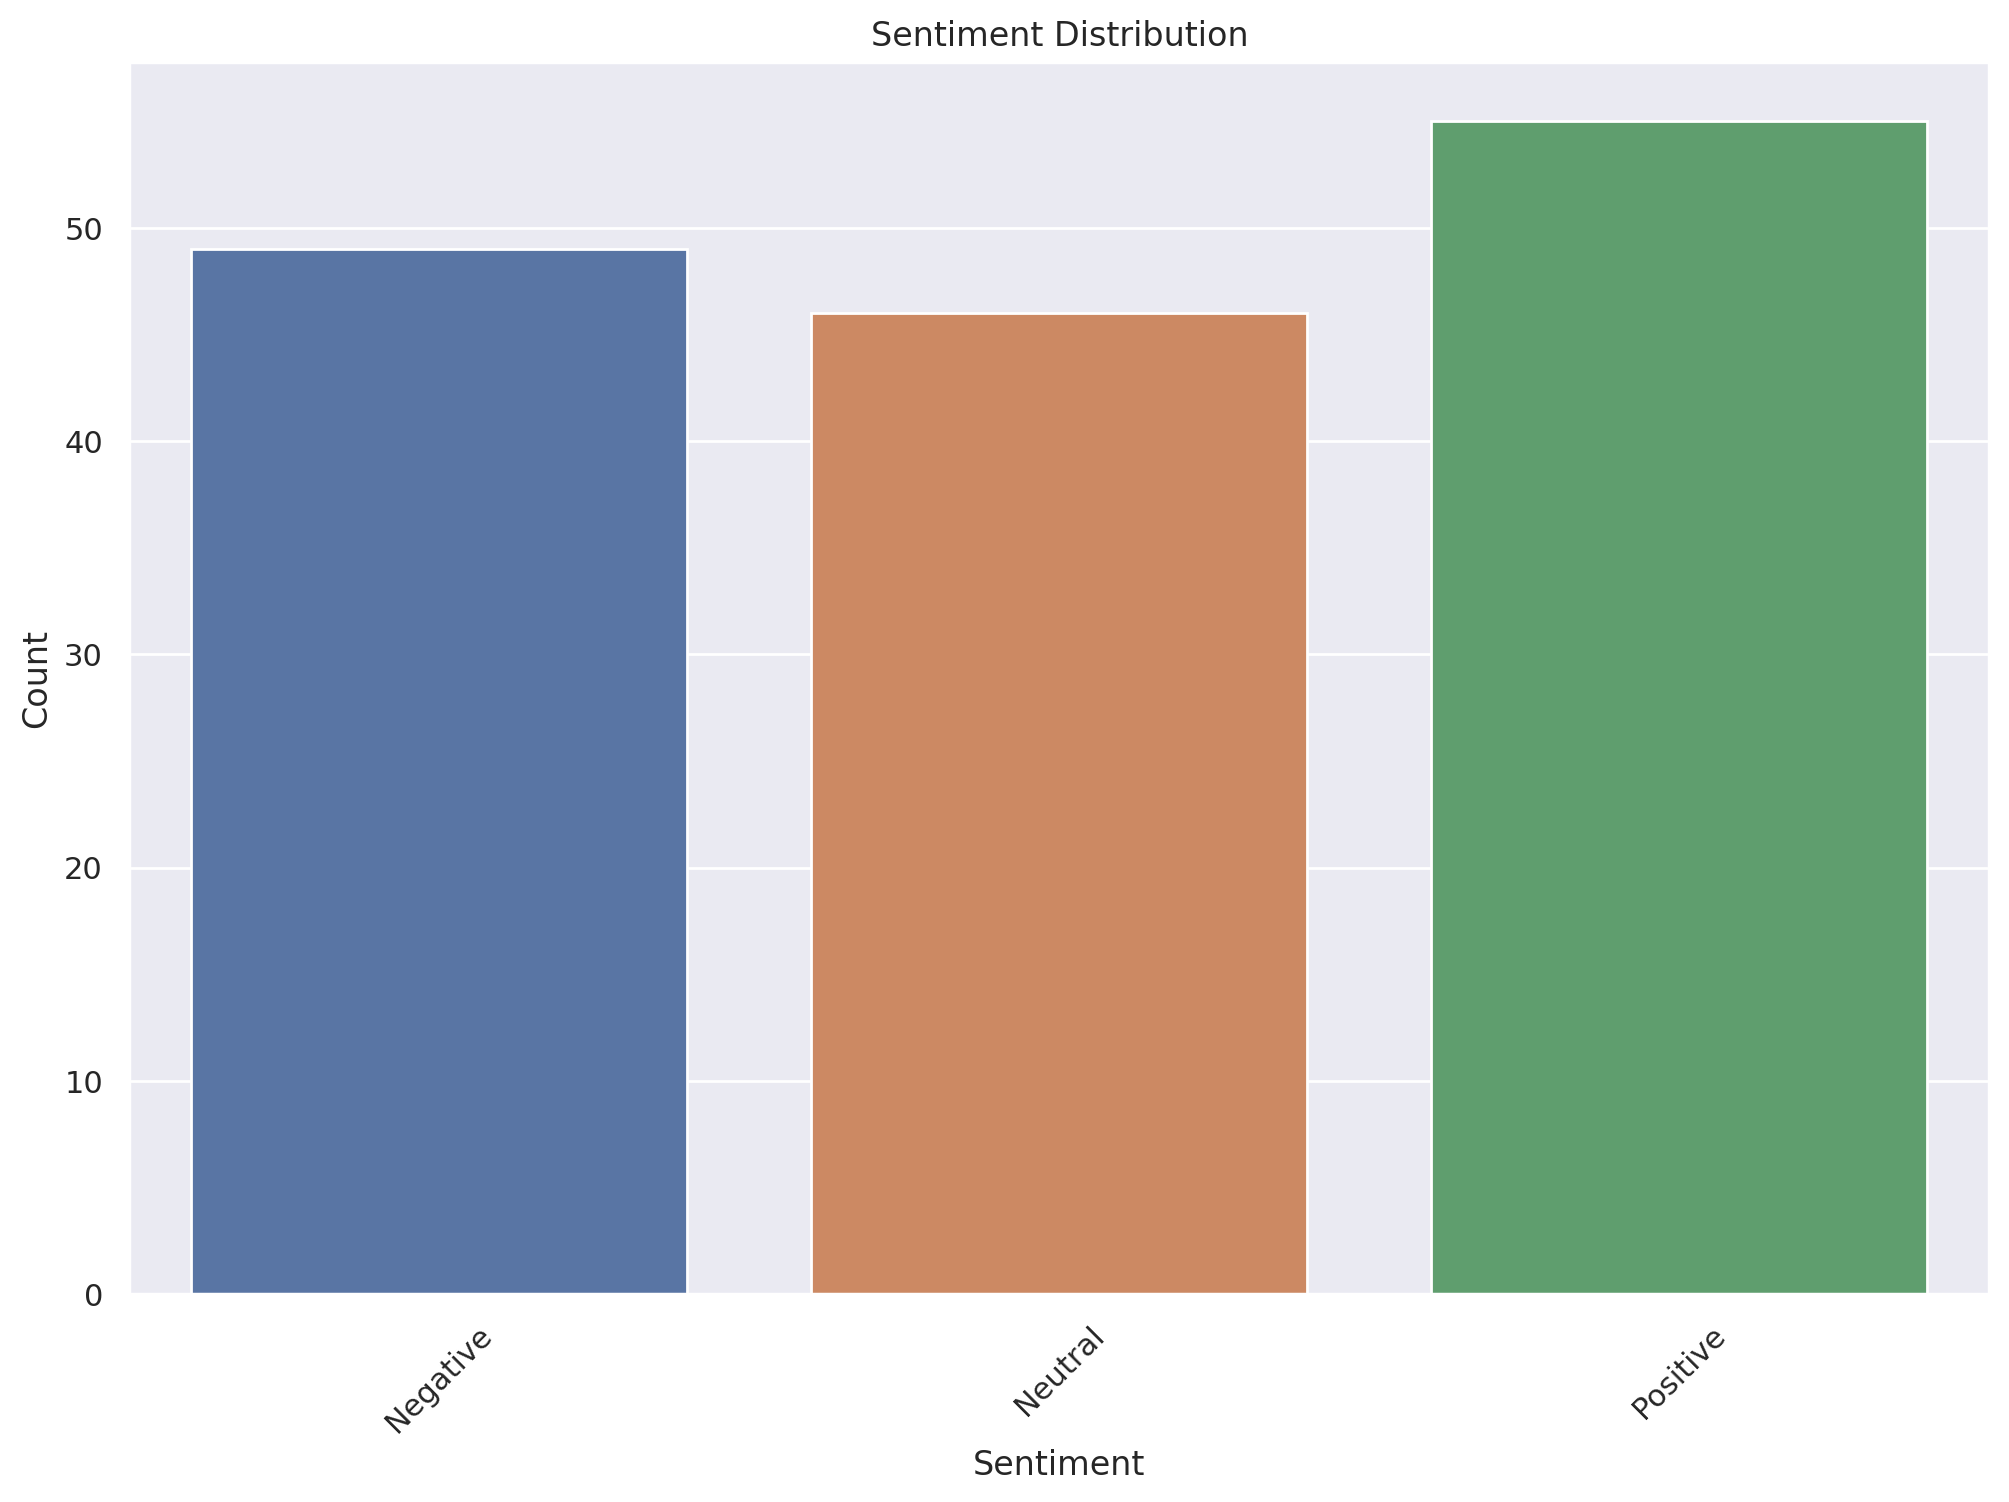

In [ ]:
import seaborn as sns
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print("Accuracy:",test_acc.item())

# Get predictions on the test set
all_preds = []
with torch.no_grad():
    for d in test_data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)

        # Get model outputs
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())

# Convert predicted labels to sentiment labels
sentiment_labels = ['Negative', 'Neutral', 'Positive']
predicted_sentiments = [sentiment_labels[pred] for pred in all_preds]

# Count the occurrences of each sentiment label
unique_labels, label_counts = np.unique(predicted_sentiments, return_counts=True)

# Set the seaborn style
sns.set(style="darkgrid")

# Create a barplot using seaborn
ax = sns.barplot(x=unique_labels, y=label_counts)
ax.set(xlabel='Sentiment', ylabel='Count', title='Sentiment Distribution')

plt.xticks(rotation=45)
plt.show()

In [ ]:
#get predictions from our model

def get_predictions(model, data_loader):
    model = model.eval()

    News = []
    predictions = []
    prediction_probs = []
    Alabels = []

    with torch.no_grad():
        for d in data_loader:
            News = d["News_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            News.extend(News)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            Alabels.extend(labels)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    Alabels = torch.stack(Alabels).cpu()

    return News, predictions, prediction_probs, Alabels

In [ ]:
y_News, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.84      0.91      0.87        45
     neutral       0.89      0.84      0.86        49
    positive       1.00      0.98      0.99        56

    accuracy                           0.91       150
   macro avg       0.91      0.91      0.91       150
weighted avg       0.92      0.91      0.91       150



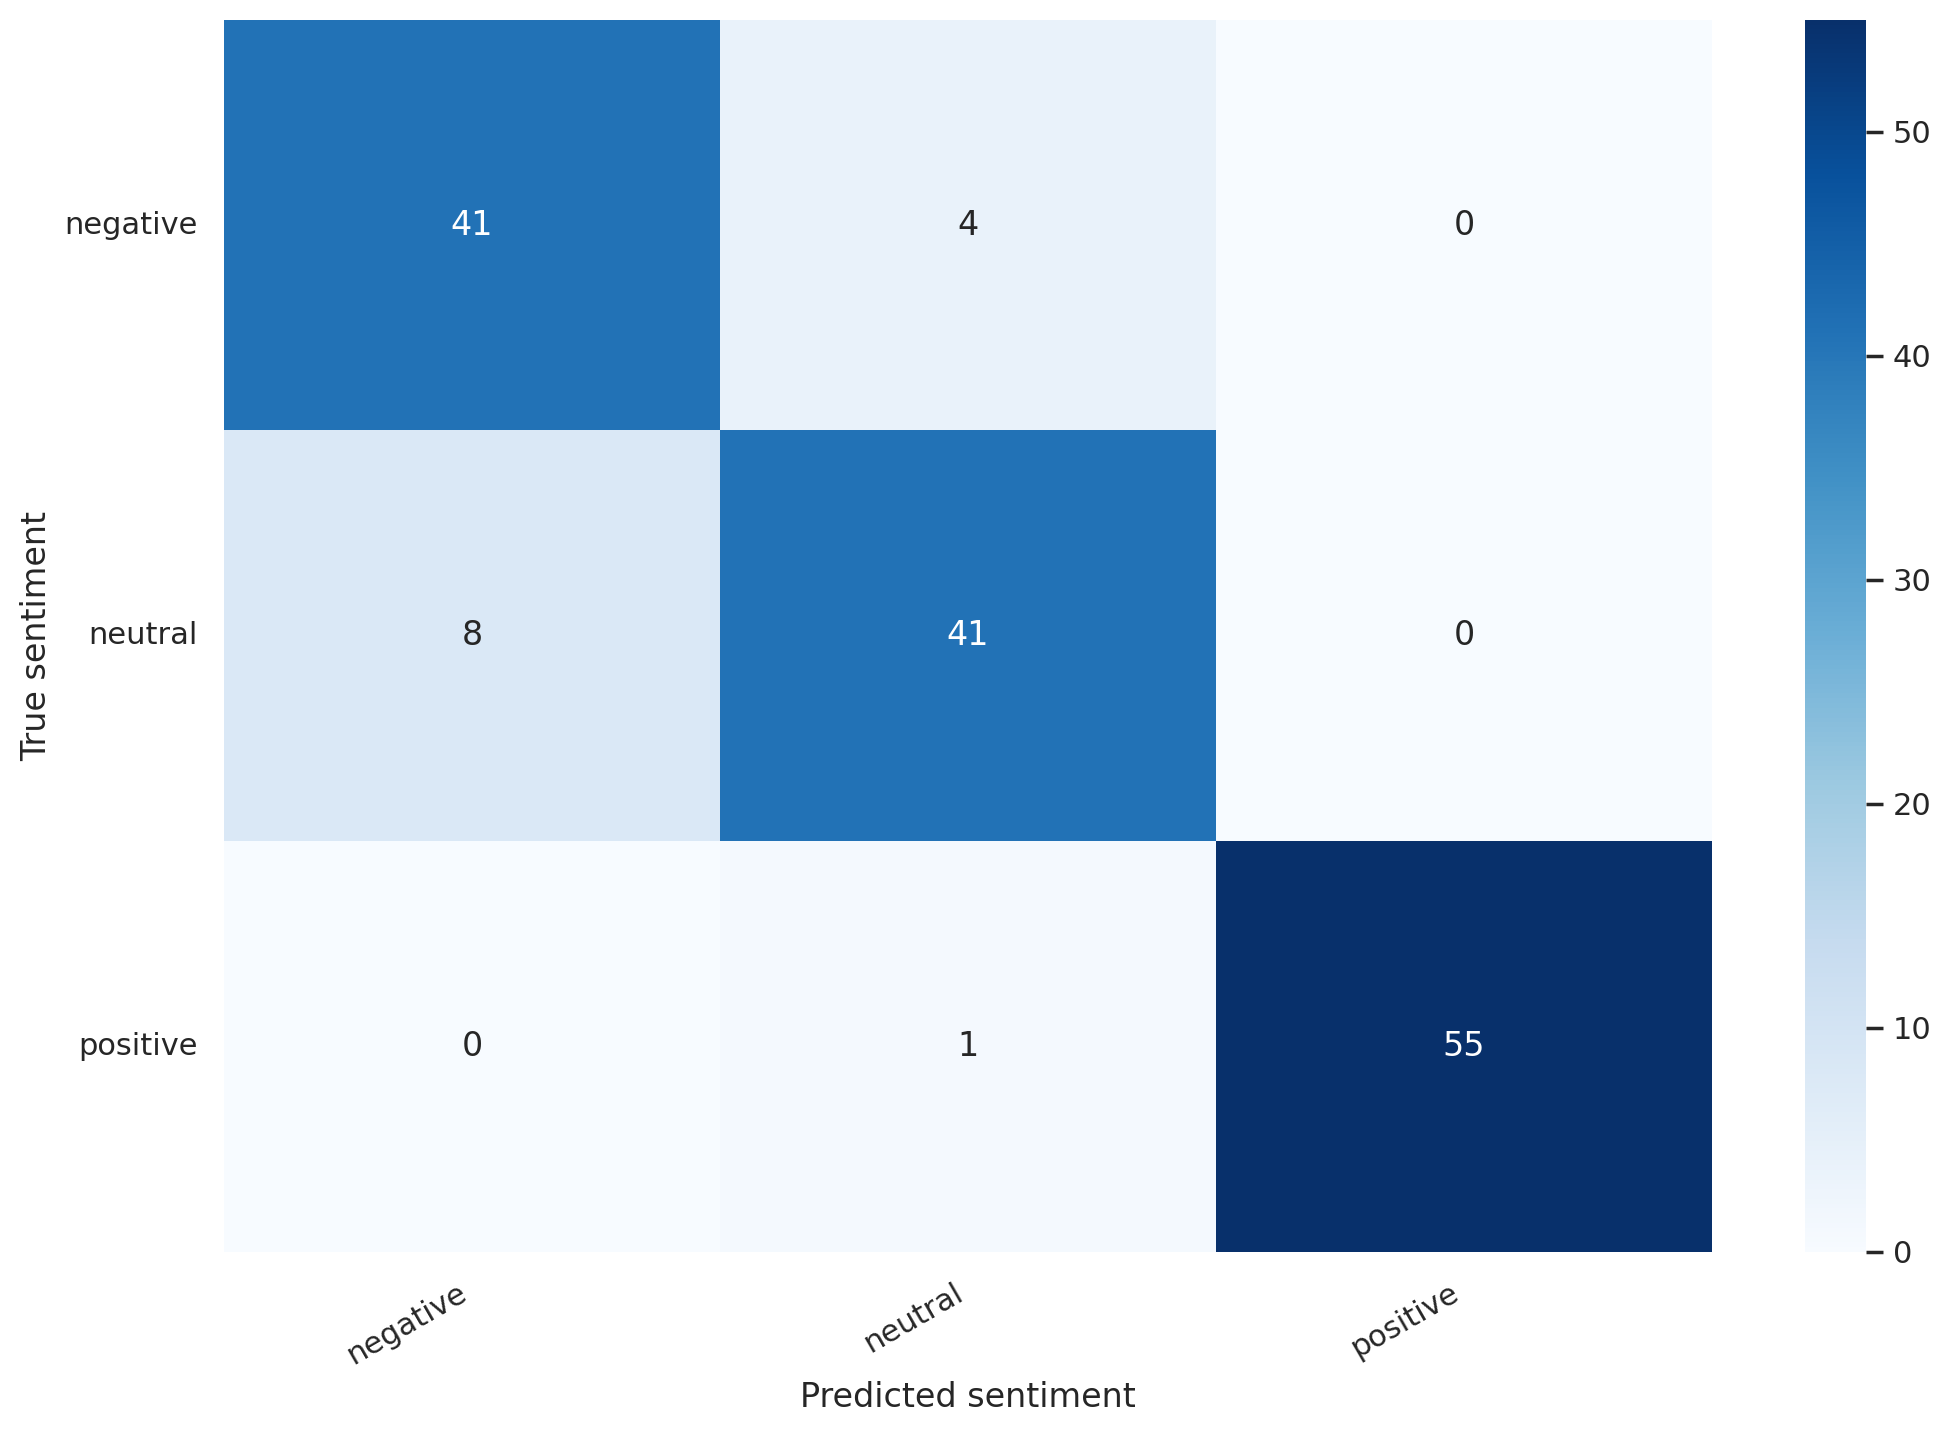

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

#Finetune a ProsusAI/finbert pretrained model

In [ ]:
!pip install transformers
!pip install torch
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup

In [ ]:
#data = pd.read_csv("/content/DataSampleAdd.csv")
data = pd.read_csv("/content/oversampled_alterloc.csv")

# Split the dataset into input texts and labels
texts = data["Title"].tolist()
labels = data["Sentiment_Label"].tolist()

# Convert labels to numerical format (0: negative, 1: neutral, 2: positive)
label_mapping = {"negative": 0, "neutral": 1, "positive": 2}
labels = [label_mapping[label] for label in labels]

In [ ]:
model_name = "ProsusAI/finbert"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
encoded_inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
input_ids = encoded_inputs["input_ids"]
attention_mask = encoded_inputs["attention_mask"]
labels = torch.tensor(labels)

In [ ]:
dataset = torch.utils.data.TensorDataset(input_ids, attention_mask, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


In [ ]:
batch_size = 16
learning_rate = 2e-5
num_epochs = 5

train_sampler = RandomSampler(train_dataset)
train_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_sampler = SequentialSampler(val_dataset)
val_loader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)


In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
#

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}

        optimizer.zero_grad()

        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        correct_predictions += (predicted_labels == batch[2]).sum().item()
        total_predictions += len(batch[2])

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions

    # Evaluate on the validation set
    model.eval()
    val_loss = 0
    val_correct_predictions = 0
    val_total_predictions = 0

    for batch in val_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}

        with torch.no_grad():
            outputs = model(**inputs)

        val_loss += outputs.loss.item()

        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        val_correct_predictions += (predicted_labels == batch[2]).sum().item()
        val_total_predictions += len(batch[2])

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct_predictions / val_total_predictions

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")
    print("-" * 10)


Epoch 1/5
Train Loss: 0.0092 | Train Accuracy: 0.9975
Val Loss: 0.3677 | Val Accuracy: 0.9100
----------
Epoch 2/5
Train Loss: 0.0077 | Train Accuracy: 0.9983
Val Loss: 0.3677 | Val Accuracy: 0.9100
----------
Epoch 3/5
Train Loss: 0.0084 | Train Accuracy: 0.9975
Val Loss: 0.3677 | Val Accuracy: 0.9100
----------
Epoch 4/5
Train Loss: 0.0077 | Train Accuracy: 0.9975
Val Loss: 0.3677 | Val Accuracy: 0.9100
----------
Epoch 5/5
Train Loss: 0.0074 | Train Accuracy: 0.9983
Val Loss: 0.3677 | Val Accuracy: 0.9100
----------


In [ ]:
model.eval()
total_correct = 0
total_loss = 0

for batch in val_loader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1)
    labels = inputs["labels"]

    total_correct += (predicted_labels == labels).sum().item()
    total_loss += outputs.loss.item()

accuracy = total_correct / len(val_dataset)
test_loss = total_loss / len(val_loader)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")



Accuracy: 91.00%
Test Loss: 0.3677


Accuracy: 91.00%
Test Loss: 0.3677


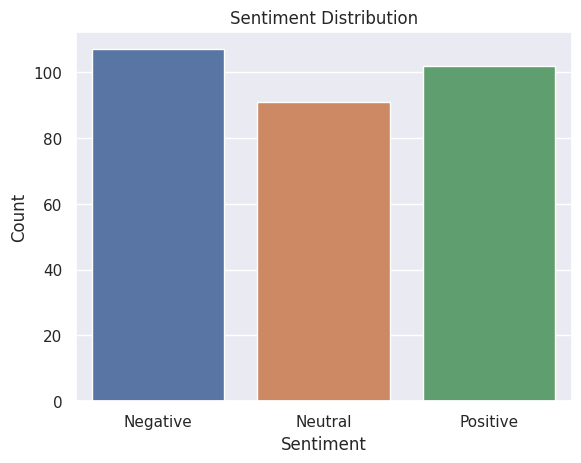

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
total_correct = 0
total_loss = 0
predicted_sentiments = []

for batch in val_loader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1)
    labels = inputs["labels"]

    total_correct += (predicted_labels == labels).sum().item()
    total_loss += outputs.loss.item()

    predicted_sentiments.extend(predicted_labels.tolist())

accuracy = total_correct / len(val_dataset)
test_loss = total_loss / len(val_loader)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Convert predicted_sentiments to a NumPy array
predicted_sentiments = np.array(predicted_sentiments)

# Compute sentiment distribution using numpy
sentiment_counts = np.bincount(predicted_sentiments)
sentiment_labels = ['Negative', 'Neutral', 'Positive']

sns.set(style="darkgrid")
ax = sns.barplot(x=sentiment_labels, y=sentiment_counts)
ax.set(xlabel='Sentiment', ylabel='Count', title='Sentiment Distribution')
plt.show()


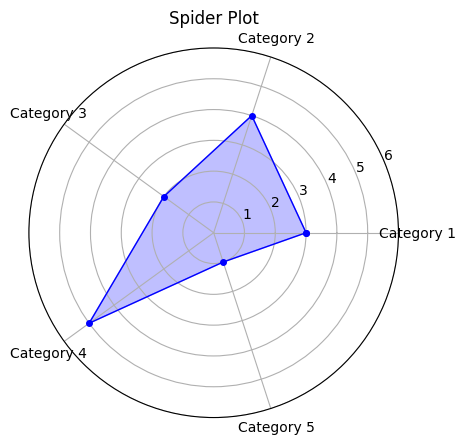

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']
values = [3, 4, 2, 5, 1]

# Number of categories
num_categories = len(categories)

# Create an array of evenly spaced angles
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

# Repeat the first angle to close the circle
angles += angles[:1]

# Extend the values array to match the length of angles
values += values[:1]

# Create a figure and axis with polar projection
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot the data
ax.plot(angles, values, linewidth=1, linestyle='solid', color='blue', marker='o', markersize=4)

# Fill the area under the line
ax.fill(angles, values, alpha=0.25, color='blue')

# Set the labels for each category
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Set the y-axis limits
ax.set_ylim(0, max(values) + 1)

# Set the title
ax.set_title('Spider Plot')

# Show the plot
plt.show()


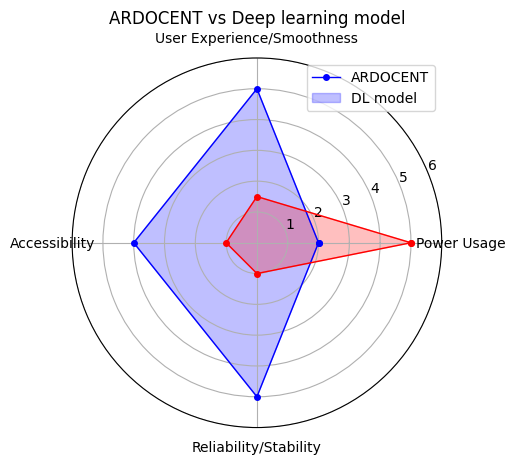

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['Power Usage', 'User Experience/Smoothness', 'Accessibility', 'Reliability/Stability']
values_set1 = [2, 5, 4, 5]
values_set2 = [5, 1.5, 1, 1]

# Number of categories
num_categories = len(categories)

# Create an array of evenly spaced angles
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

# Repeat the first angle to close the circle
angles += angles[:1]

# Extend the values arrays to match the length of angles
values_set1 += values_set1[:1]
values_set2 += values_set2[:1]

# Create a figure and axis with polar projection
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot values for set 1
ax.plot(angles, values_set1, linewidth=1, linestyle='solid', color='blue', marker='o', markersize=4)

# Fill the area under the line for set 1
ax.fill(angles, values_set1, alpha=0.25, color='blue')

# Plot values for set 2
ax.plot(angles, values_set2, linewidth=1, linestyle='solid', color='red', marker='o', markersize=4)

# Fill the area under the line for set 2
ax.fill(angles, values_set2, alpha=0.25, color='red')

# Set the labels for each category
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Set the y-axis limits
ax.set_ylim(0, max(max(values_set1), max(values_set2)) + 1)

# Set the title
ax.set_title('ARDOCENT vs Deep learning model')

# Create a legend
ax.legend(['ARDOCENT', 'DL model'])

# Show the plot
plt.show()


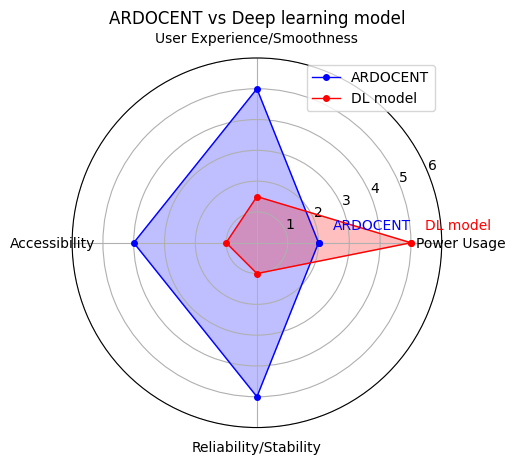

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['Power Usage', 'User Experience/Smoothness', 'Accessibility', 'Reliability/Stability']
values_set1 = [2, 5, 4, 5]
values_set2 = [5, 1.5, 1, 1]

# Number of categories
num_categories = len(categories)

# Create an array of evenly spaced angles
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

# Repeat the first angle to close the circle
angles += angles[:1]

# Extend the values arrays to match the length of angles
values_set1 += values_set1[:1]
values_set2 += values_set2[:1]

# Create a figure and axis with polar projection
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot values for set 1
line1, = ax.plot(angles, values_set1, linewidth=1, linestyle='solid', color='blue', marker='o', markersize=4)

# Fill the area under the line for set 1
ax.fill(angles, values_set1, alpha=0.25, color='blue')

# Plot values for set 2
line2, = ax.plot(angles, values_set2, linewidth=1, linestyle='solid', color='red', marker='o', markersize=4)

# Fill the area under the line for set 2
ax.fill(angles, values_set2, alpha=0.25, color='red')

# Set the labels for each category
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Set the y-axis limits
ax.set_ylim(0, max(max(values_set1), max(values_set2)) + 1)

# Set the title
ax.set_title('ARDOCENT vs Deep learning model')

# Create legends for each plot
ax.legend([line1, line2], ['ARDOCENT', 'DL model'])

# Add labels to the lines
ax.annotate('ARDOCENT', xy=(angles[0], values_set1[0]), xytext=(10,10), textcoords='offset points', color='blue')
ax.annotate('DL model', xy=(angles[0], values_set2[0]), xytext=(10,10), textcoords='offset points', color='red')

# Show the plot
plt.show()


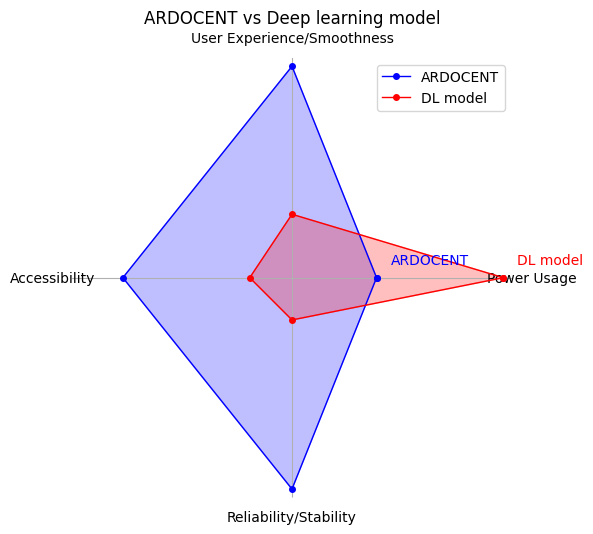

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['Power Usage', 'User Experience/Smoothness', 'Accessibility', 'Reliability/Stability']
values_set1 = [2, 5, 4, 5]
values_set2 = [5, 1.5, 1, 1]

# Number of categories
num_categories = len(categories)

# Create an array of evenly spaced angles
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

# Repeat the first angle to close the circle
angles += angles[:1]

# Extend the values arrays to match the length of angles
values_set1 += values_set1[:1]
values_set2 += values_set2[:1]

# Create a figure and axis with polar projection
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})

# Plot values for set 1
line1, = ax.plot(angles, values_set1, linewidth=1, linestyle='solid', color='blue', marker='o', markersize=4)

# Fill the area under the line for set 1
ax.fill(angles, values_set1, alpha=0.25, color='blue')

# Plot values for set 2
line2, = ax.plot(angles, values_set2, linewidth=1, linestyle='solid', color='red', marker='o', markersize=4)

# Fill the area under the line for set 2
ax.fill(angles, values_set2, alpha=0.25, color='red')

# Set the labels for each category
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Remove radial labels and grid lines
ax.set_yticklabels([])
ax.yaxis.grid(False)

# Remove polar axes
ax.spines['polar'].set_visible(False)

# Set the title
ax.set_title('ARDOCENT vs Deep learning model')

# Create legends for each plot
ax.legend([line1, line2], ['ARDOCENT', 'DL model'])

# Add labels to the lines
ax.annotate('ARDOCENT', xy=(angles[0], values_set1[0]), xytext=(10, 10), textcoords='offset points', color='blue')
ax.annotate('DL model', xy=(angles[0], values_set2[0]), xytext=(10, 10), textcoords='offset points', color='red')

# Adjust layout to fit the plot
plt.tight_layout()

# Show the plot
plt.show()


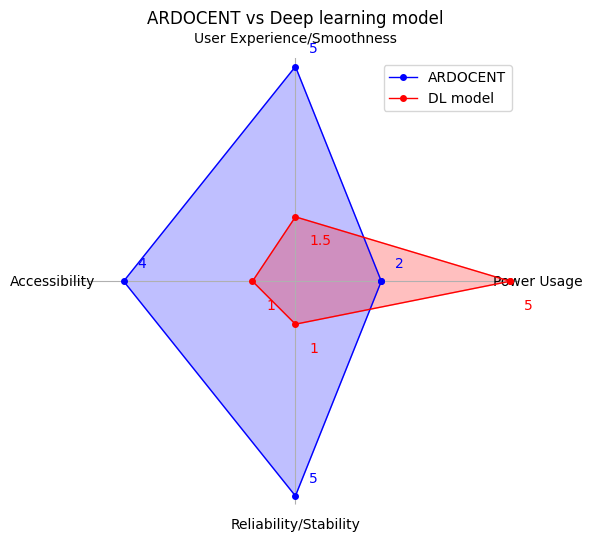

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['Power Usage', 'User Experience/Smoothness', 'Accessibility', 'Reliability/Stability']
values_set1 = [2, 5, 4, 5]
values_set2 = [5, 1.5, 1, 1]

# Number of categories
num_categories = len(categories)

# Create an array of evenly spaced angles
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

# Repeat the first angle to close the circle
angles += angles[:1]

# Extend the values arrays to match the length of angles
values_set1 += values_set1[:1]
values_set2 += values_set2[:1]

# Create a figure and axis with polar projection
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})

# Plot values for set 1
line1, = ax.plot(angles, values_set1, linewidth=1, linestyle='solid', color='blue', marker='o', markersize=4)

# Fill the area under the line for set 1
ax.fill(angles, values_set1, alpha=0.25, color='blue')

# Plot values for set 2
line2, = ax.plot(angles, values_set2, linewidth=1, linestyle='solid', color='red', marker='o', markersize=4)

# Fill the area under the line for set 2
ax.fill(angles, values_set2, alpha=0.25, color='red')

# Set the labels for each category
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Remove radial labels and grid lines
ax.set_yticklabels([])
ax.yaxis.grid(False)

# Remove polar axes
ax.spines['polar'].set_visible(False)

# Set the title
ax.set_title('ARDOCENT vs Deep learning model')

# Create legends for each plot
ax.legend([line1, line2], ['ARDOCENT', 'DL model'])

# Add labels to the lines
for angle, value_set1, value_set2 in zip(angles[:-1], values_set1[:-1], values_set2[:-1]):
    ax.annotate(str(value_set1), xy=(angle, value_set1), xytext=(10, 10), textcoords='offset points', color='blue')
    ax.annotate(str(value_set2), xy=(angle, value_set2), xytext=(10, -20), textcoords='offset points', color='red')

# Adjust layout to fit the plot
plt.tight_layout()

# Show the plot
plt.show()


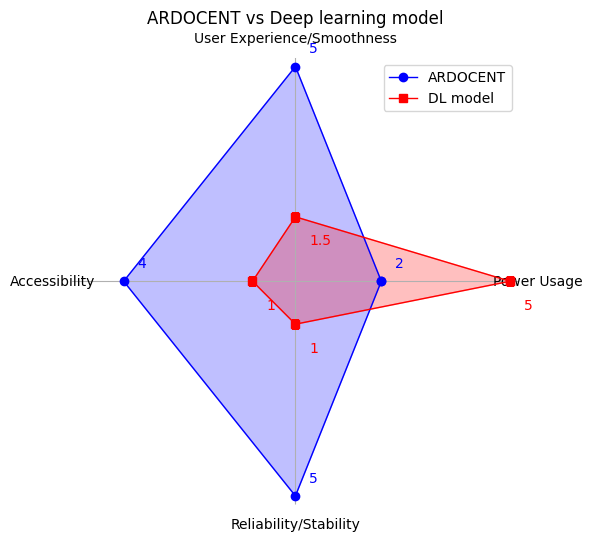

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['Power Usage', 'User Experience/Smoothness', 'Accessibility', 'Reliability/Stability']
values_set1 = [2, 5, 4, 5]
values_set2 = [5, 1.5, 1, 1]

# Number of categories
num_categories = len(categories)

# Create an array of evenly spaced angles
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

# Repeat the first angle to close the circle
angles += angles[:1]

# Extend the values arrays to match the length of angles
values_set1 += values_set1[:1]
values_set2 += values_set2[:1]

# Create a figure and axis with polar projection
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})

# Plot values for set 1 with different marker styles
line1, = ax.plot(angles, values_set1, linewidth=1, linestyle='solid', color='blue', marker='o', markersize=6)

# Fill the area under the line for set 1
ax.fill(angles, values_set1, alpha=0.25, color='blue')

# Plot values for set 2 with different marker styles
line2, = ax.plot(angles, values_set2, linewidth=1, linestyle='solid', color='red', marker='s', markersize=6)

# Fill the area under the line for set 2
ax.fill(angles, values_set2, alpha=0.25, color='red')

# Set the labels for each category
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Remove radial labels and grid lines
ax.set_yticklabels([])
ax.yaxis.grid(False)

# Remove polar axes
ax.spines['polar'].set_visible(False)

# Set the title
ax.set_title('ARDOCENT vs Deep learning model')

# Create legends for each plot
ax.legend([line1, line2], ['ARDOCENT', 'DL model'])

# Add labels to the lines
for angle, value_set1, value_set2 in zip(angles[:-1], values_set1[:-1], values_set2[:-1]):
    ax.annotate(str(value_set1), xy=(angle, value_set1), xytext=(10, 10), textcoords='offset points', color='blue')
    ax.annotate(str(value_set2), xy=(angle, value_set2), xytext=(10, -20), textcoords='offset points', color='red')

# Adjust layout to fit the plot
plt.tight_layout()

# Show the plot
plt.show()


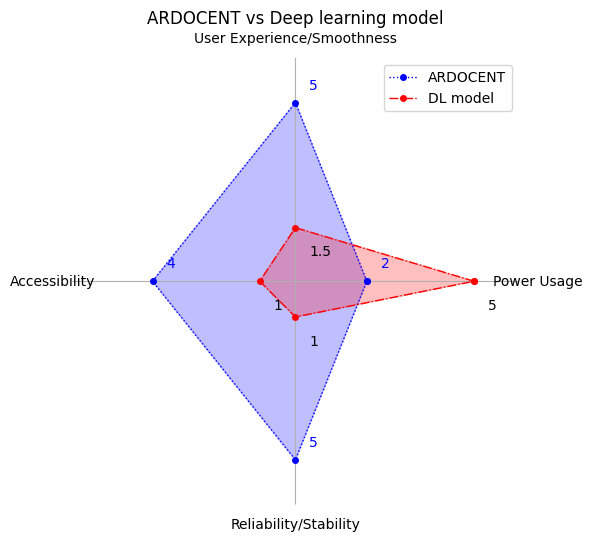

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['Power Usage', 'User Experience/Smoothness', 'Accessibility', 'Reliability/Stability']
values_set1 = [2, 5, 4, 5]
values_set2 = [5, 1.5, 1, 1]

# Number of categories
num_categories = len(categories)

# Create an array of evenly spaced angles
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

# Repeat the first angle to close the circle
angles += angles[:1]

# Extend the values arrays to match the length of angles
values_set1 += values_set1[:1]
values_set2 += values_set2[:1]

# Create a figure and axis with polar projection
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})

# Plot values for set 1 with dotted line
line1, = ax.plot(angles, values_set1, linewidth=1, linestyle='dotted', color='blue', marker='o', markersize=4)

# Fill the area under the line for set 1
ax.fill(angles, values_set1, alpha=0.25, color='blue')

# Plot values for set 2 with dotted-dash line
line2, = ax.plot(angles, values_set2, linewidth=1, linestyle='-.', color='red', marker='o', markersize=4)

# Fill the area under the line for set 2
ax.fill(angles, values_set2, alpha=0.25, color='red')

# Add dotted parallel lines for values from 1 to 6
for value in range(1, 7):
    line = plt.Line2D([0, 2 * np.pi], [value] * 2, linestyle='dotted', color='black')
    ax.add_line(line)

# Set the labels for each category
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Remove radial labels and grid lines
ax.set_yticklabels([])
ax.yaxis.grid(False)

# Remove polar axes
ax.spines['polar'].set_visible(False)

# Set the title
ax.set_title('ARDOCENT vs Deep learning model')

# Create legends for each plot
ax.legend([line1, line2], ['ARDOCENT', 'DL model'])

# Add labels to the lines
for angle, value_set1, value_set2 in zip(angles[:-1], values_set1[:-1], values_set2[:-1]):
    ax.annotate(str(value_set1), xy=(angle, value_set1), xytext=(10, 10), textcoords='offset points', color='blue')
    ax.annotate(str(value_set2), xy=(angle, value_set2), xytext=(10, -20), textcoords='offset points')

# Adjust layout to fit the plot
plt.tight_layout()

# Show the plot
plt.show()


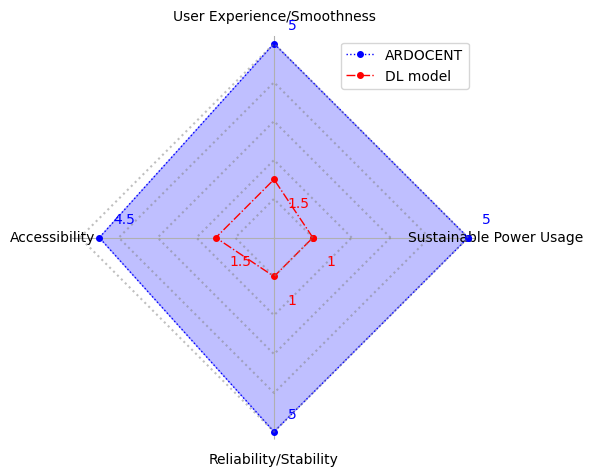

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['Sustainable Power Usage', 'User Experience/Smoothness', 'Accessibility', 'Reliability/Stability']
values_set1 = [5, 5, 4.5, 5]
values_set2 = [1, 1.5, 1.5, 1]

# Number of categories
num_categories = len(categories)

# Create an array of evenly spaced angles
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

# Repeat the first angle to close the circle
angles += angles[:1]

# Extend the values arrays to match the length of angles
values_set1 += values_set1[:1]
values_set2 += values_set2[:1]

# Create a figure and axis with polar projection
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})

# Plot values for set 1 with dotted line
line1, = ax.plot(angles, values_set1, linewidth=1, linestyle=':', color='blue', marker='o', markersize=4)

# Fill the area under the line for set 1
ax.fill(angles, values_set1, alpha=0.25, color='blue')

# Plot values for set 2 with dotted-dash line
line2, = ax.plot(angles, values_set2, linewidth=1, linestyle='-.', color='red', marker='o', markersize=4)

# Set the labels for each category
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Remove radial labels and grid lines
ax.set_yticklabels([])
ax.yaxis.grid(False)

# Remove polar axes
ax.spines['polar'].set_visible(False)

# Set the title
# ax.set_title('ARDOCENT vs Deep learning model')

# Create legends for each plot
ax.legend([line1, line2], ['ARDOCENT', 'DL model'])

# Add labels to the lines
for angle, value_set1, value_set2 in zip(angles[:-1], values_set1[:-1], values_set2[:-1]):
    ax.annotate(str(value_set1), xy=(angle, value_set1), xytext=(10, 10), textcoords='offset points', color='blue')
    ax.annotate(str(value_set2), xy=(angle, value_set2), xytext=(10, -20), textcoords='offset points', color='red')

# Draw dotted lines for the values 1 to 5 across x and y axis
for i in range(1, 6):
    ax.plot(angles, [i] * len(angles), linestyle=':', color='gray', alpha=0.5)
    #ax.plot([i] * len(angles), angles, linestyle=':', color='gray', alpha=0.5)

# Adjust layout to fit the plot
plt.tight_layout()

# Show the plot
plt.show()


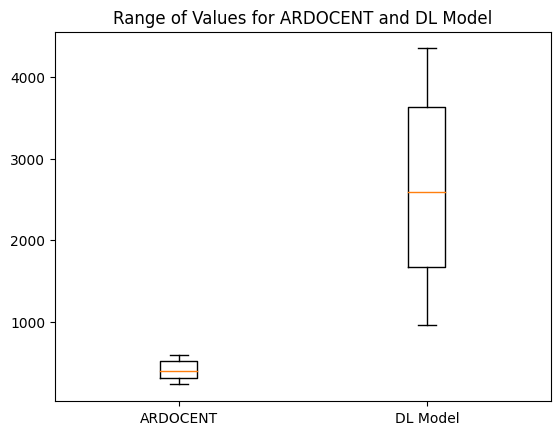

In [ ]:
import matplotlib.pyplot as plt

# Sample data for ARDOCENT and DL model-based applications
ardocent_data = [236.402, 320.209, 405.053, 520.03, 593.7048]
dl_model_data = [958.274, 1673.6, 2590.712, 3635.849, 4347.495]

# Combine the data into a single list
data = [ardocent_data, dl_model_data]

# Create a figure and axis
fig, ax = plt.subplots()

# Create a box plot
boxplot = ax.boxplot(data)

# Add labels to the x-axis
ax.set_xticklabels(['ARDOCENT', 'DL Model'])

# Add a title
ax.set_title('Range of Values for ARDOCENT and DL Model')

# Show the plot
plt.show()


In [ ]:
import plotly.graph_objects as go

# Sample data for ARDOCENT and DL model-based applications
ardocent_data = [236.402, 320.209, 405.053, 520.03, 593.7048]
dl_model_data = [958.274, 1673.6, 2590.712, 3635.849, 4347.495]

# Create a box plot for ARDOCENT
fig = go.Figure()
fig.add_trace(go.Box(y=ardocent_data, name='ARDOCENT'))

# Create a box plot for DL Model
fig.add_trace(go.Box(y=dl_model_data, name='DL Model'))

# Customize layout
fig.update_layout(
    title='Range of Values for ARDOCENT and DL Model',
    xaxis=dict(title='Application'),
    yaxis=dict(title='Values'),
    width=700,  # Set the width of the plot
    height=500,  # Set the height of the plot
)

# Show the plot
fig.show()


In [ ]:
import plotly.graph_objects as go

# Sample data for ARDOCENT and DL model-based applications
ardocent_data = [236.402, 320.209, 405.053, 520.03, 593.7048]
dl_model_data = [958.274, 1673.6, 2590.712, 3635.849, 4347.495]

# Create a box plot for ARDOCENT
fig = go.Figure()
fig.add_trace(go.Box(y=ardocent_data, name='ARDOCENT'))

# Create a box plot for DL Model
fig.add_trace(go.Box(y=dl_model_data, name='DL Model'))

# Customize layout
fig.update_layout(
    title='Energy consumption values across multiple scenarios',
    xaxis=dict(title='Application'),
    yaxis=dict(title='Energy consumption values'),
    width=550,  # Set the width of the plot
    height=500,  # Set the height of the plot
    legend=dict(
        orientation="h",  # Set the orientation to horizontal
        yanchor="top",  # Anchor the legend to the top of the plot
        y=1.1,  # Adjust the y position
        xanchor="center",  # Anchor the legend to the center
    )
)

# Show the plot
fig.show()


In [ ]:
import plotly.graph_objects as go

# Sample data for ARDOCENT and DL model-based applications
ardocent_data = [236.402, 320.209, 405.053, 520.03, 593.7048]
dl_model_data = [958.274, 1673.6, 2590.712, 3635.849, 4347.495]

# Create a box plot for ARDOCENT
fig = go.Figure()
fig.add_trace(go.Box(y=ardocent_data, name='ARDOCENT'))

# Create a box plot for DL Model
fig.add_trace(go.Box(y=dl_model_data, name='DL Model'))

# Customize layout
fig.update_layout(
    # title='Range of Values for ARDOCENT and DL Model',
    # title_font=dict(color='black'),  # Set title color to black
    xaxis=dict(title='Application', title_font=dict(color='black')),  # Set x-axis title color to black
    yaxis=dict(title='Energy consumption (Joules)', title_font=dict(color='black')),  # Set y-axis title color to black
    width=500,  # Set the width of the plot
    height=500,  # Set the height of the plot
    margin=dict(l=0, r=0, t=0, b=0),  # Set margin values to 0
    legend=dict(
        orientation="h",  # Set the orientation to horizontal
        yanchor="top",  # Anchor the legend to the top of the plot
        y=1.1,  # Adjust the y position
        xanchor="center",  # Anchor the legend to the center
        font=dict(color='black')  # Set legend font color to black
    ),
)

# Show the plot
fig.show()
